Try to compute DCR for a given SED.

First, we'll use the code that generates Figure 2 in the paper.

Let's tweak it so we can try to use the supernova spectrum.

In [2]:
import os
import numpy as np

#import dcr
from chroma import spec    ## dont forget to add $HOME/GIT_REPOS/chroma/chroma to PYTHONPATH before starting ipython notebook
#import plot
#import utils

#import _mypath
#import chroma

datadir = '/Users/dreiss/GIT_REPOS/chroma/data/'

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.style.use('ggplot')
from matplotlib import cm

## see http://matplotlib.org/users/colormaps.html for colormaps

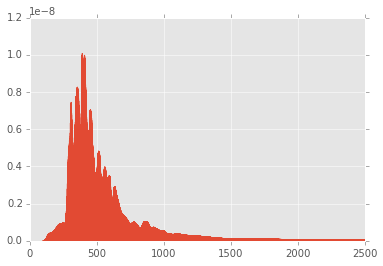

In [3]:
from scipy.interpolate import interp1d

tmp,w,f = np.genfromtxt(datadir + 'SEDs/snflux_1a.dat').T
w /= 10. ## convert from angstroms to nm?
ss = interp1d(w, f)

sn_SED = spec.SED(ss)
wave = np.arange(500.0, 901.0, 1.0)
photons = sn_SED(wave)

plt.plot(ss.x, ss.y)

In [4]:
%load_ext rpy2.ipython

In [6]:
%%R 
sn_spec <- read.delim('chroma/data/SEDs/snflux_1a.dat', sep='', head=F)
print(head(sn_spec))
print(which(sn_spec$V2==max(sn_spec$V2)))


Error in file(file, "rt") : cannot open the connection


Aha, the SN Ia spec is multiple spectra - let's extract the last one. (first one looks very weird)

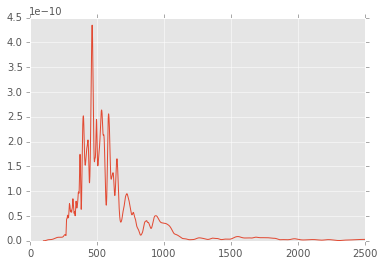

In [7]:
plt.plot(w[252105:254506], f[252105:254506])

SN Ia at redshift 0.5.

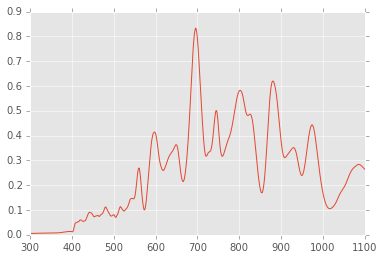

In [8]:
ss = interp1d(w[252105:254506], f[252105:254506])
#plt.plot(ss.x, ss.y)

sn_SED = spec.SED(ss).atRedshift(0.5)
wave = np.arange(300.0, 1101.0, 1.0)
photons = sn_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 900)].max()
plt.plot(wave, photons/scale)

Looks like spec has a few useful functions like 

```
calculateDCRMomentShifts(self, bandpass, **kwargs):
```

        @returns a tuple.  The first element is the vector of DCR first moment shifts, and the
                 second element is the 2x2 matrix of DCR second (central) moment shifts.


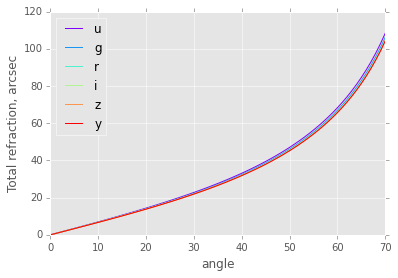

In [9]:
# filters are stored in two columns: wavelength (nm), and throughput
#filter_ = 'i'
import pandas as pd
angles = np.linspace(0,70,71)
df = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
for i, filter_ in enumerate('ugrizy'):
    fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
    fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
    #plt.plot(fwave, throughput)
    shifts = np.array( [sn_SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0)[0].item(1) 
                        for angle in angles])
    shifts = shifts * 3600.0 * 180.0/np.pi
    df = pd.concat([df, pd.Series(shifts)], axis=1, ignore_index=True)
    #print shifts
    #plt.plot(np.linspace(0,60,13,endpoint=True), shifts)

df.columns = np.insert(np.array(list('ugrizy'), dtype='S6'), 0, 'angle')
df = df.set_index('angle')
ax = df.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction, arcsec')

In [10]:
## see: https://stackoverflow.com/questions/19536817/manipulate-html-module-font-size-in-ipython-notebook
class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)
sizeme(df.head())

,u,g,r,i,z,y
angle,,,,,,
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.688515,0.674474,0.667807,0.664853,0.663087,0.662155
2,1.377449,1.349360,1.336022,1.330111,1.326579,1.324714
3,2.067224,2.025069,2.005052,1.996180,1.990880,1.988081
4,2.758262,2.702015,2.675307,2.663469,2.656397,2.652662


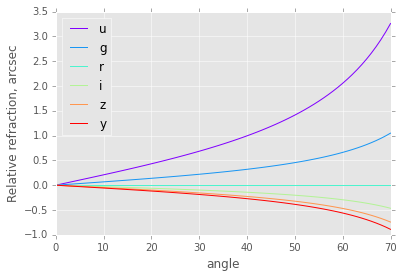

In [11]:
df2 = df.copy().sub(df['r'], axis=0)
#sizeme(df2.head())
ax = df2.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction, arcsec')

Sa galaxy at redshift 0.6

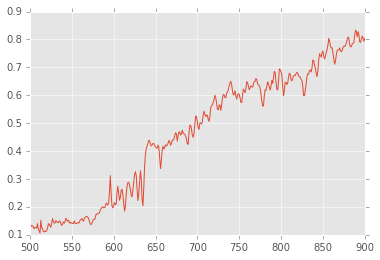

In [12]:
#gal_SED = spec.SED(datadir+'/SEDs/'+'KIN_Sa_ext.ascii')
w,f = np.genfromtxt(datadir+'SEDs/KIN_Sa_ext.ascii').T
#toAppend = np.arange(w.max()+0.5,1200.,0.5)
#w = np.append(w, toAppend)
#f = np.append(f, np.zeros_like(toAppend))
ss = interp1d(w, f)

gal_SED = spec.SED(ss).atRedshift(0.6)
wave = np.arange(500.0, 901.0, 1.0)
photons = gal_SED(wave)

scale = 1.2 * photons[(wave > 500) & (wave < 1000)].max()
plt.plot(wave, photons/scale)

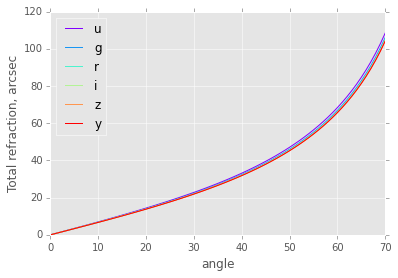

In [13]:
#angles = np.linspace(0,70,71)
df_gal = pd.DataFrame(pd.Series(angles)) #, index=pd.Series(angles))
for i, filter_ in enumerate('ugrizy'):
    fdata = spec.Bandpass(datadir+'filters/LSST_{}.dat'.format(filter_))
    fwave, throughput = fdata.wave_list, fdata(fdata.wave_list)
    #plt.plot(fwave, throughput)
    shifts = np.array( [gal_SED.calculateDCRMomentShifts(fdata, zenith_angle=angle * np.pi/180.0)[0].item(1) 
                        for angle in angles])
    shifts = shifts * 3600.0 * 180.0/np.pi
    df_gal = pd.concat([df_gal, pd.Series(shifts)], axis=1, ignore_index=True)
    #print shifts
    #plt.plot(np.linspace(0,60,13,endpoint=True), shifts)

df_gal.columns = np.insert(np.array(list('ugrizy'), dtype='S6'), 0, 'angle')
df_gal = df_gal.set_index('angle')
ax = df_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('Total refraction, arcsec')

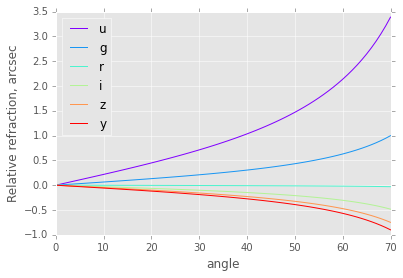

In [14]:
df2_gal = df_gal.copy().sub(df['r'], axis=0)
#sizeme(df2_gal.head())
ax = df2_gal.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction, arcsec')

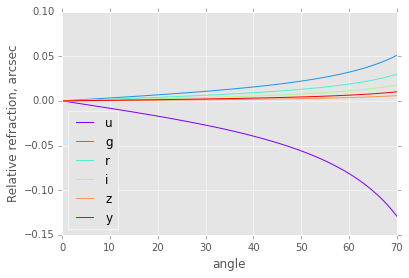

In [15]:
df_tmp = df - df_gal
sizeme(df_tmp.head())
ax = df_tmp.plot(colormap=cm.rainbow)
ax.set_ylabel('Relative refraction, arcsec')